In [24]:
import math
import os ; os.environ['CUDA_VISIBLE_DEVICES'] = "-1"
import numpy as np
import torch
import random
from collections import defaultdict
from tqdm.notebook import tqdm

import sys ; sys.path.insert(0, "../code/")
from utils import get_common_path
from data import load_data
from torch_utils import get_model_class
from time_metric import get_best

import matplotlib
from matplotlib import pyplot as plt

import seaborn as sns
sns.set(font_scale = 1.8)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['lines.linewidth'] = 4
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['lines.markersize'] = 14
matplotlib.rcParams['ps.fonttype'] = 42
# matplotlib.rcParams['xtick.labelsize'] = 18
# matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['axes.xmargin'] = 0.1
matplotlib.rcParams['axes.ymargin'] = 0.1
matplotlib.rc('font', **{'weight': 'normal', 'size': 28})
# plt.style.use('dark_background')

DATASET = "once"
EVAL_K = 20

In [25]:
def get_fusion_type(common, model_type):
    if "fusion" not in common: return None
    
    if model_type == "RecFormer_future":
        return common.split("_fusion_")[1].split("_train_K_")[0] 
    return common.split("_fusion_")[1].split("_bsz_")[0] 

def extract(common, model_type):
    return {
        'latent_size': int(common.split("_latent_size_")[1].split("_")[0]),
        'weight_decay': float(common.split("_wd_")[1].split("_")[0]),
        'lr': float(common.split("_lr_")[1].split("_")[0]),
        'batch_size': int(common.split("_bsz_")[1].split("_")[0]),
        'dropout': float(common.split("_dropout_")[1].split("_")[0]),
        
        ## Future
        'train_K': int(common.split("_train_K_")[1].split("_")[0]) if "train_K" in common else None,
        'future_decay': common.split("_decay_")[1].split("_")[0] if "_decay_" in common else None,
        
        ## Sequential
        'max_seq_len': int(common.split("_max_seq_len_")[1].split("_")[0]) if "max_seq_len" in common else None,
        'seq_step_size': int(common.split("_seq_step_")[1].split("_")[0]) if "seq_step" in common else None,
        
        ## SASRec
        'num_blocks': int(common.split("_blocks_")[1].split("_")[0]) if "blocks" in common else None,
        'num_heads': int(common.split("_heads_")[1].split("_")[0]) if "heads" in common else None,
        'transformer_seq_len': int(common.split("_transformer_len_")[1].split("_")[0]) if "transformer_len" in common else None,
        
        ## RecFormer
        'recformer_fusion': get_fusion_type(common, model_type),
        
        'model_type':           model_type,
        'dataset':              DATASET,
        'eval_K':               EVAL_K,
        'pad_with':             0.0,
        'train_test_split':     'last_10_percent'
    }

def get_best_model(model_type, print_metrics = True):
    BASE = "../results/{}/logs/".format(DATASET)
    all_logs = os.listdir(BASE)
    all_logs = list(map(lambda x: BASE + x, all_logs))
    metric, log_file = get_best(
        all_logs, model_type, EVAL_K, 
        VAL_METRIC = "RMSE_mean"
        # VAL_METRIC = "RMSE_{}".format(EVAL_K)
    )
    if log_file is None: return None
    common = log_file.split("/")[-1][:-4]
    
    hyper_params = extract(common, model_type)
    
    hyper_params['model_path'] = "../results/{}/models/{}.pt".format(DATASET, common)
    
    if print_metrics:
        print(model_type)
        print({ k: metric[0][k] for k in [ 'RMSE_mean', 'RMSE_1' ] }) #, 'RMSE_25', 'RMSE_50', 'RMSE_75', 'RMSE_100' ] })
    return hyper_params

In [26]:
class PointLoader:
    def __init__(self): 
        self.rnn_reader, self.context_size = self.load_reader("RNN")
            
        self.model_config = { 
#             "NN": self.load("MF"), 
#             "NN-f": self.load("MF_Future"),

#             "RNN": self.load("RNN"),
            r"RNN-\textsc{Horizon}": self.load("RNN_future"),

#             "Transformer": self.load("SASRec"),
#             r"Transformer-\textsc{Horizon}": self.load("SASRec_future"),
            
#             "RecFormer": self.load("RecFormer"),
#             r"\textsc{GapFormer-Horizon}": self.load("RecFormer_future")
        }
        
    def is_sequential(self, model_type):
        return model_type in { 
            "RNN", "RNN_future", "RNN-f",
            "SASRec", "SASRec_future", "Transformer", "Transformer-f",
            "RecFormer", "RecFormer_future", "RecFormer-f",
            r"RNN-\textsc{Horizon}", r"Transformer-\textsc{Horizon}", r"\textsc{GapFormer-Horizon}"
        }
    
    def is_future_model(self, model_type):
        return model_type in { 
            "RNN_future", "SASRec_future", "RecFormer_future",
            r"RNN-\textsc{Horizon}", r"Transformer-\textsc{Horizon}", r"\textsc{GapFormer-Horizon}"
        }
    
    def un_normalize_dist(self, dist):
        return self.rnn_reader.un_normalize_dist(dist)

    def load_reader(self, model_type):
        hyper_params = get_best_model(model_type, print_metrics=False)
        if hyper_params is None: return None, None

        hyper_params['max_seq_len'] = 6_000 if DATASET == "openacc" else 4_000 # Keep it maximum and shorten it later
        train_reader, test_reader, val_reader, hyper_params = load_data(hyper_params)
        # return val_reader, hyper_params['context_size']
        return test_reader, hyper_params['context_size']
        
    # Load best model
    def load(self, model_type):
        hyper_params = get_best_model(model_type)
        if hyper_params is None: return None, None

        # train_reader, test_reader, val_reader, hyper_params = load_data(hyper_params)
        hyper_params['context_size'] = self.context_size
        hyper_params['is_future_model'] = self.is_future_model(model_type)

        model = get_model_class(hyper_params)(hyper_params)
        model.load_state_dict(torch.load(
            hyper_params['model_path'], 
            map_location = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        ))
        model.eval()
        # print(model)
        return model
            
    def __call__(self):
        # Randomly sample rnn_data
        self.all_d = []
        for data, y in self.rnn_reader: self.all_d.append([ data, y] )
        max_seq_data, max_seq_y = random.choice(self.all_d)
        
        choose_index = random.choice(list(range(max_seq_data[0].shape[0])))

        for i in range(len(max_seq_data)):
            max_seq_data[i] = max_seq_data[i][choose_index].unsqueeze(0)  
        for i in range(len(max_seq_y)):
            max_seq_y[i] = max_seq_y[i][choose_index].unsqueeze(0)
            
#         test_length = self.rnn_reader.test_lengths[choose_index]
#         starting_point = -random.choice(list(range(1, test_length)))
#         max_seq_data[0] = max_seq_data[0][:, :-starting_point]
#         max_seq_data[1] = max_seq_data[1][:, :-starting_point]
#         max_seq_y[0] = max_seq_y[0][:, :-starting_point]
#         max_seq_y[1] = max_seq_y[1][:, :-starting_point]

        # Construct MF-data from rnn_data
        mf_data = [
            None,
            max_seq_data[0][:, -EVAL_K],
            max_seq_data[0][:, -(EVAL_K+1)],
            max_seq_data[1][:, -EVAL_K:, :],
            max_seq_data[1][:, -(EVAL_K+1):-1, :]
        ]
        mf_y = max_seq_y[1][:, -1]
        
        # data = {}
        data = { 
            "NN": (mf_data, mf_y), 
            "NN-f": (mf_data, mf_y)
        }
        
        for model_type in [
#             "RNN", 
#             "RNN-f", 
            r"RNN-\textsc{Horizon}",
            # "s-RNN", "s-RNN-f",
            # "Transformer", 
#             "Transformer-f", 
#             r"Transformer-\textsc{Horizon}",
            # "s-Transformer", "s-Transformer-f",
#             "RecFormer", 
#             "RecFormer-f", 
#             r"\textsc{GapFormer-Horizon}"
        ]:
            max_seq_len = self.model_config[model_type].hyper_params['max_seq_len']
            data[model_type] = ([
                max_seq_data[0][:, -max_seq_len:],
#                 max_seq_data[1][:, -max_seq_len:],
                max_seq_data[1][:, -max_seq_len:, :],
#                 max_seq_data[3][:, -max_seq_len:, :]
            ], max_seq_y)

        return data

def clamp(arr): return list(map(lambda x: max(x, 0.0), arr))
    
point_loader = PointLoader()

# of users: 10
# of items: 0
RNN_future
{'RMSE_mean': 9.3857, 'RMSE_1': 6.8651}


FileNotFoundError: [Errno 2] No such file or directory: 'once/no_perturb.pdf'

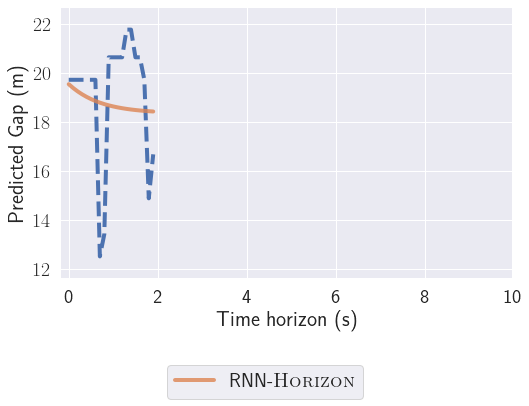

In [27]:
def get_random_output(data, y, model, is_sequential_model):
    with torch.no_grad():

        curr_weather = np.argmax(data[-1][0, 0][1:5].cpu().numpy())

        def perturb_weather():
            if is_sequential_model:
                curr_distance, context = data
                perturbed_in = [ curr_distance, context ]
            else:
                user, curr_distance, prev_distance, context, prev_context = data
                perturbed_in = [ user, curr_distance, prev_distance, context, prev_context ]

            perturbed_out = point_loader.un_normalize_dist(model(*perturbed_in, eval = True))
            return perturbed_out[0].cpu().detach().numpy()

        if is_sequential_model: 
            y_mask, y = y
            return y[0, -1].cpu().detach().numpy(), \
                   perturb_weather()[-1]
        else:
            return y[0].cpu().detach().numpy(), \
                   perturb_weather()

fig, p = plt.subplots(1, 1, figsize = (8, 6))

random_data = point_loader()

for at, (title, model) in enumerate(point_loader.model_config.items()):

    data, y = random_data[title]
    is_sequential = point_loader.is_sequential(title)

    y_new, predicted = get_random_output(data, y, model, is_sequential)

    TO_PLOT = 100

    if at == 0: p.plot(list(range(len(y_new)))[:TO_PLOT], y_new[:TO_PLOT], '--')

    p.plot(
        list(range(len(y_new)))[:TO_PLOT], 
        clamp(predicted[:TO_PLOT]), 
        '-', 
        label = title,
        alpha = 0.8
    )

p.set_ylabel("Predicted Gap (m)")
p.set_xlabel("Time horizon (s)")
xticks = list(range(0, TO_PLOT + 1, 10))[::2]
p.set_xticks(xticks)
p.set_xticklabels(map(lambda x: str(x // 10), xticks))

# fig.suptitle("Current weather: " + curr_weather)
fig.tight_layout()
plt.subplots_adjust(bottom = 0.3)
fig.legend(loc = 8, ncol = 4, bbox_to_anchor = (0.5, 0))
for t in [ "pdf", "png" ]: fig.savefig("{}/no_perturb.{}".format(DATASET, t))

## How does weather affect the predictions?
(Only for Toyota)

In [28]:
if DATASET == "toyota":
    original_weather_map = {
        1: 'clear',
        2: 'cloudy',
        3: 'foggy',
        4: 'light rain',
        5: 'heavy rain',
        6: 'light snow',
        7: 'heavy snow',
        8: 'storm'
    }

    # Final to human-readable
    preprocess_weather_map = {
        0: 1,
        1: 8,
        2: 3,
        3: 2
    }

    def get_random_output(data, y, model, is_sequential_model):
        with torch.no_grad():
            
            curr_weather = np.argmax(data[-1][0, 0][1:5].cpu().numpy())
            
            def perturb_weather(new_weather, curr_distance, prev_distance, context, prev_context):
                perturbed_context = torch.clone(context)
                perturbed_context[0, :, 1 + curr_weather] = 0
                perturbed_context[0, :, 1 + new_weather] = 1.0
                
                if is_sequential_model:
                    perturbed_in = [ curr_distance, perturbed_context ]
                else:
                    perturbed_prev_context = torch.clone(prev_context)
                    perturbed_prev_context[0, :, 1 + curr_weather] = 0
                    perturbed_prev_context[0, :, 1 + new_weather] = 1.0
                    perturbed_in = [ user, curr_distance, prev_distance, perturbed_context, perturbed_prev_context ]

                perturbed_out = point_loader.un_normalize_dist(model(*perturbed_in, eval = True))
                return perturbed_out[0].cpu().detach().numpy()
            
            if is_sequential_model: 
                curr_distance, context = data ; y_mask, y = y
                return y[0, -1].cpu().detach().numpy(), \
                       [ perturb_weather(i, curr_distance, None, context, None)[-1] for i in range(4) ], \
                       original_weather_map[preprocess_weather_map[curr_weather]]
            else:
                user, curr_distance, prev_distance, context, prev_context = data
                return y[0].cpu().detach().numpy(), \
                       [ perturb_weather(i, curr_distance, prev_distance, context, prev_context) for i in range(4) ], \
                       original_weather_map[preprocess_weather_map[curr_weather]]

    num_cols = 3
    num_rows = math.ceil(len(point_loader.model_config) / num_cols)
    fig, ax = plt.subplots(num_rows, num_cols, figsize = (6 * num_cols, 6 * num_rows))
    if num_rows == 1: ax = np.array([ ax ])
    
    random_data = point_loader()

    for at, (title, model) in enumerate(point_loader.model_config.items()):
            
        data, y = random_data[title]
        is_sequential = point_loader.is_sequential(title)
            
        y_new, all_weathers, curr_weather = get_random_output(data, y, model, is_sequential)

        TO_PLOT = 100

        p = ax[at // num_cols][at % num_cols]
        p.plot(list(range(len(y_new)))[:TO_PLOT], y_new[:TO_PLOT], '--')
        for i in range(len(all_weathers)):
            p.plot(
                list(range(len(y_new)))[:TO_PLOT], 
                clamp(all_weathers[i][:TO_PLOT]), 
                '-', 
                label = original_weather_map[preprocess_weather_map[i]] if at == 0 else None
            )
        p.set_title(title)
        p.set_ylabel("Predicted Gap (m)")
        p.set_xlabel("Time horizon (s)")
        xticks = list(map(int, np.linspace(0, TO_PLOT, 6))) # list(range(0, TO_PLOT + 1, 10))
        p.set_xticks(xticks)
        p.set_xticklabels(map(lambda x: str(x // 10), xticks))

    fig.suptitle("Current weather: " + curr_weather)
    fig.tight_layout()
    plt.subplots_adjust(bottom = 0.29)
    fig.legend(loc = 8, ncol = 4)
    for t in [ "pdf", "png" ]: fig.savefig("{}/perturb_weather.{}".format(DATASET, t))

## How does the vehicle affect the prediction?

ValueError: attempt to get argmax of an empty sequence

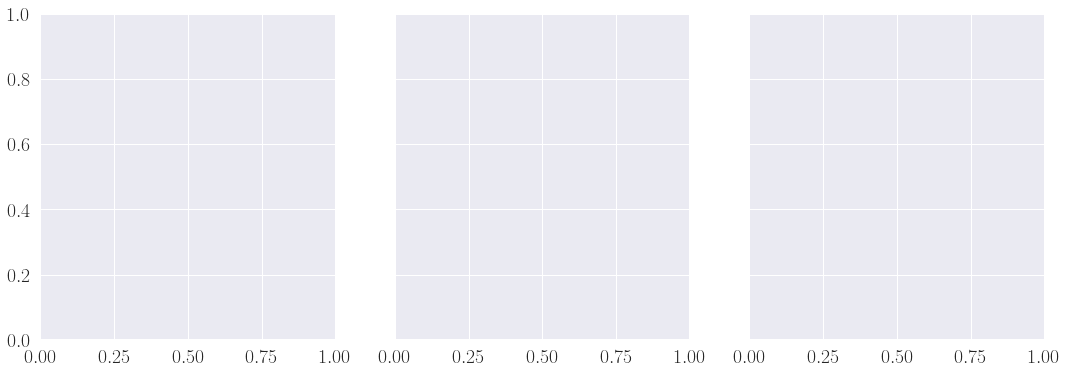

In [29]:
if DATASET == "toyota":
    rev_car_map = {'sedan': 0, 'SUV': 1}
    car_map = {}
    for i in rev_car_map: car_map[rev_car_map[i]] = i
    cars_to_test = [ 
        [ 'sedan', 'Sedan'], 
        [ 'SUV', 'SUV' ]
    ]
else:
    rev_car_map = { 
        'Hyundai Ioniq hybrid': 0, 
        'Volvo XC40': 1, 
        'Tesla Model-X': 2, 
        'Tesla Model-3': 3, 
        'BMW X5': 4, 
        'Audi A6': 5, 
        'Mercedes A-Class': 6, 
        'Ford S-Max': 7, 
        'Peugeot 3008 GTLine': 8, 
        'KIA Niro': 9, 
        'Mini Cooper': 10, 
        'Mitsubishi Outlander PHEV': 11, 
        'Hyundai': 12, 
        'Ford': 13
    }
    car_map = {}
    for i in rev_car_map: car_map[rev_car_map[i]] = i

    cars_to_test = [
        [ 'Tesla Model-X', 'Tesla Model-X' ], # SUV
        [ 'Tesla Model-3', 'Tesla Model-3' ], # Sedan
        [ 'Mercedes A-Class', 'Mercedes A-Class' ], # Compact
        [ 'Mini Cooper', 'Mini Cooper' ] # Sub-compact
    ]

def get_random_output(data, y, model, is_sequential_model):
    with torch.no_grad():
        
        start_index = 2 if DATASET == 'openacc' else 5 # toyota
        curr_vehicle = np.argmax(data[-1][0, 0][start_index:].cpu().numpy())
        
        def perturb_vehicle(new_vehicle, curr_distance, prev_distance, context, prev_context):    
            perturbed_context = torch.clone(context)
            perturbed_context[0, :, start_index + curr_vehicle] = 0
            perturbed_context[0, :, start_index + new_vehicle] = 1.0
            
            if is_sequential_model:
                perturbed_in = [ curr_distance, perturbed_context ]
            else:
                perturbed_prev_context = torch.clone(prev_context)
                perturbed_prev_context[0, :, start_index + curr_vehicle] = 0
                perturbed_prev_context[0, :, start_index + new_vehicle] = 1.0
                perturbed_in = [ user, curr_distance, prev_distance, perturbed_context, perturbed_prev_context ]

            perturbed_out = point_loader.un_normalize_dist(model(*perturbed_in, eval = True))
            return perturbed_out[0].cpu().detach().numpy()

        if is_sequential_model: 
            curr_distance, context = data ; y_mask, y = y
            return y[0, -1].cpu().detach().numpy(), \
                   [ perturb_vehicle(rev_car_map[i], curr_distance, None, context, None)[-1] for i, _ in cars_to_test ], \
                   car_map[curr_vehicle]
        else:
            user, curr_distance, prev_distance, context, prev_context = data
            return y[0].cpu().detach().numpy(), \
                   [ perturb_vehicle(rev_car_map[i], curr_distance, prev_distance, context, prev_context) for i, _ in cars_to_test ], \
                   car_map[curr_vehicle]

num_cols = 3
num_rows = math.ceil(len(point_loader.model_config) / num_cols)
fig, ax = plt.subplots(num_rows, num_cols, figsize = (6 * num_cols, 6 * num_rows), sharey=True)
if num_rows == 1: ax = np.array([ ax ])

random_data = point_loader()

for at, (title, model) in enumerate(point_loader.model_config.items()):

    data, y = random_data[title]
    is_sequential = point_loader.is_sequential(title)

    y_new, all_cars, curr_vehicle = get_random_output(data, y, model, is_sequential)

    TO_PLOT = 100
    
    p = ax[at // num_cols][at % num_cols]
    p.plot(list(range(len(y_new)))[:TO_PLOT], y_new[:TO_PLOT], '--', label = curr_vehicle if at == 0 else None)
    
    for at2, (i, plot_name) in enumerate(cars_to_test):
        p.plot(list(range(len(y_new)))[:TO_PLOT], clamp(all_cars[at2][:TO_PLOT]), '-', label = plot_name if at == 0 else None)
    
    p.set_title(title)
    p.set_ylabel("Predicted Gap (m)")
    p.set_xlabel("Time horizon (s)")
    xticks = list(map(int, np.linspace(0, TO_PLOT, 6)))
    p.set_xticks(xticks)
    p.set_xticklabels(map(lambda x: str(x // 10), xticks))

# fig.suptitle("Dataset: {} ; Current vehicle: {}".format(DATASET, curr_vehicle))
# fig.suptitle("Current vehicle: {}".format(curr_vehicle))
fig.tight_layout()
plt.subplots_adjust(bottom = 0.29)
fig.legend(loc = 8, ncol = 5)
for t in [ "pdf", "png" ]: fig.savefig("{}/perturb_vehicle.{}".format(DATASET, t))

## How do the predictions change with low vs. high existing gaps?

FileNotFoundError: [Errno 2] No such file or directory: 'once/perturb_gap.pdf'

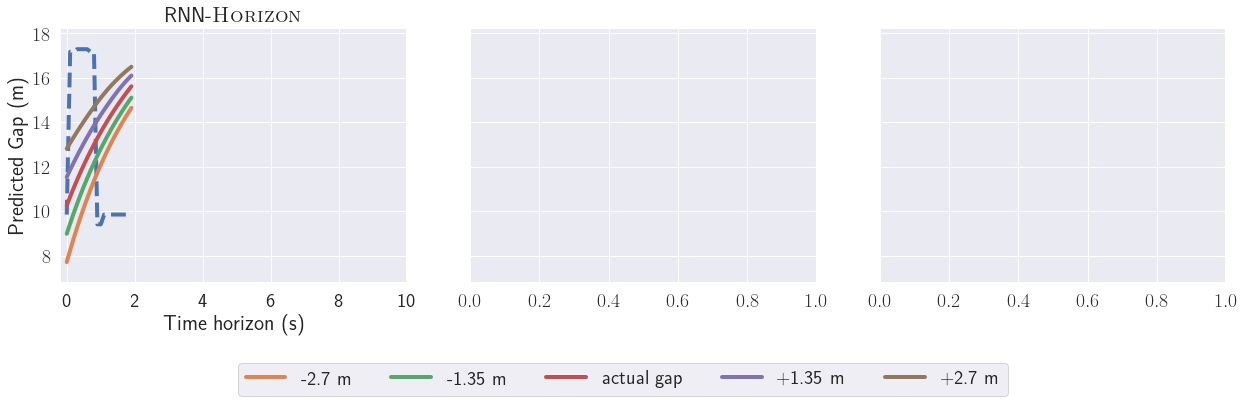

In [30]:
def get_random_output(data, y, model, is_sequential_model):
    with torch.no_grad():
        
        def perturb_gap(delta, curr_distance, prev_distance, context, prev_context):
            perturbed_distance = torch.clone(curr_distance)
            perturbed_distance += delta
            
            if is_sequential_model:
                perturbed_in = [ perturbed_distance, context ]
            else:
                perturbed_prev_distance = torch.clone(prev_distance)
                perturbed_prev_distance += delta
                perturbed_in = [ user, perturbed_distance, perturbed_prev_distance, context, prev_context ]

            perturbed_out = point_loader.un_normalize_dist(model(*perturbed_in, eval = True))
            return perturbed_out[0].cpu().detach().numpy()
        
        if is_sequential_model: 
            curr_distance, context = data ; y_mask, y = y
            return y[0, -1].cpu().detach().numpy(), \
                   [ perturb_gap(i, curr_distance, None, context, None)[-1] for i in [ -0.2, -0.1, 0.0, 0.1, 0.2 ] ]
        else:
            user, curr_distance, prev_distance, context, prev_context = data
            return y[0].cpu().detach().numpy(), \
                   [ perturb_gap(i, curr_distance, prev_distance, context, prev_context) for i in [ -0.2, -0.1, 0.0, 0.1, 0.2 ] ]

num_cols = 3
num_rows = math.ceil(len(point_loader.model_config) / num_cols)
fig, ax = plt.subplots(num_rows, num_cols, figsize = (6 * num_cols, 6 * num_rows), sharey = True)
if num_rows == 1: ax = np.array([ ax ])

random_data = point_loader()

for at, (title, model) in enumerate(point_loader.model_config.items()):

    data, y = random_data[title]
    is_sequential = point_loader.is_sequential(title)
        
    y_new, (v_neg, neg, actual, pos, v_pos) = get_random_output(data, y, model, is_sequential)

    TO_PLOT = 100
    
    step = round(point_loader.un_normalize_dist(0.1) - point_loader.un_normalize_dist(0.0), 2)
    
    p = ax[at // num_cols][at % num_cols]
    p.plot(list(range(len(y_new)))[:TO_PLOT], y_new[:TO_PLOT], '--')
    p.plot(list(range(len(y_new)))[:TO_PLOT], clamp(v_neg[:TO_PLOT]), '-', label = "-{} m".format(2 * step) if at == 0 else None)
    p.plot(list(range(len(y_new)))[:TO_PLOT], clamp(neg[:TO_PLOT]), '-', label = "-{} m".format(step) if at == 0 else None)
    p.plot(list(range(len(y_new)))[:TO_PLOT], clamp(actual[:TO_PLOT]), '-', label = "actual gap" if at == 0 else None)
    p.plot(list(range(len(y_new)))[:TO_PLOT], clamp(pos[:TO_PLOT]), '-', label = "+{} m".format(step) if at == 0 else None)
    p.plot(list(range(len(y_new)))[:TO_PLOT], clamp(v_pos[:TO_PLOT]), '-', label = "+{} m".format(2 * step) if at == 0 else None)
    p.set_title(title)
    p.set_ylabel("Predicted Gap (m)")
    p.set_xlabel("Time horizon (s)")
    xticks = list(map(int, np.linspace(0, TO_PLOT, 6)))
    p.set_xticks(xticks)
    p.set_xticklabels(map(lambda x: str(x // 10), xticks))
    
# fig.suptitle("Dataset: {}".format(DATASET))
fig.tight_layout()
plt.subplots_adjust(bottom = 0.29)
fig.legend(loc = 8, ncol = 5)
for t in [ "pdf", "png" ]: fig.savefig("{}/perturb_gap.{}".format(DATASET, t))

## How do the predictions change with low vs. high car speeds?

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

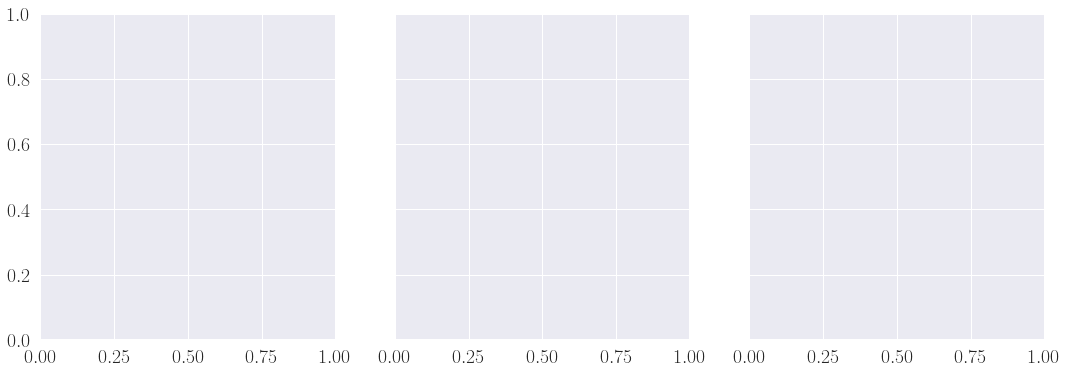

In [31]:
def get_random_output(data, y, model, is_sequential_model):
    with torch.no_grad():
        
        def perturb_speed(delta, curr_distance, prev_distance, context, prev_context):
            perturbed_context = torch.clone(context)
            perturbed_context[:, :, 0] += delta
            
            if is_sequential_model:
                perturbed_in = [ curr_distance, perturbed_context ]
            else:
                perturbed_prev_context = torch.clone(prev_context)
                perturbed_prev_context[:, :, 0] += delta
                perturbed_in = [ user, curr_distance, prev_distance, perturbed_context, perturbed_prev_context ]

            perturbed_out = point_loader.un_normalize_dist(model(*perturbed_in, eval = True))
            return perturbed_out[0].cpu().detach().numpy()
        
        if is_sequential_model: 
            curr_distance, context = data ; y_mask, y = y
            return y[0, -1].cpu().detach().numpy(), \
                   [ perturb_speed(i, curr_distance, None, context, None)[-1] for i in [ -0.4, -0.2, 0.0, 0.2, 0.4 ] ]
        else:
            user, curr_distance, prev_distance, context, prev_context = data
            return y[0].cpu().detach().numpy(), \
                   [ perturb_speed(i, curr_distance, prev_distance, context, prev_context) for i in [ -0.8, -0.4, 0.0, 0.4, 0.8 ] ]

num_cols = 3
num_rows = math.ceil(len(point_loader.model_config) / num_cols)
fig, ax = plt.subplots(num_rows, num_cols, figsize = (6 * num_cols, 6 * num_rows), sharey=True)
if num_rows == 1: ax = np.array([ ax ])

random_data = point_loader()

for at, (title, model) in enumerate(point_loader.model_config.items()):

    data, y = random_data[title]
    is_sequential = point_loader.is_sequential(title)
        
    y_new, (v_neg, neg, actual, pos, v_pos) = get_random_output(data, y, model, is_sequential)

    TO_PLOT = 100
    
    def unnorm_speed(s):
        if DATASET == "toyota":
            mean, std = 24.98804581373602, 8.643135111273233 # Toyota
        elif DATASET == "openacc":
            mean, std = 23.943490826960645, 8.956184268635134 # OpenACC
        else:
            mean, std = None, None
        return (float(s) * std) + mean
    
    step = round(unnorm_speed(0.4) - unnorm_speed(0.0), 2)

    p = ax[at // num_cols][at % num_cols]
    p.plot(list(range(len(y_new)))[:TO_PLOT], y_new[:TO_PLOT], '--')
    p.plot(list(range(len(y_new)))[:TO_PLOT], clamp(v_neg[:TO_PLOT]), '-', label = "-{} m/s".format(2 * step) if at == 0 else None)
    p.plot(list(range(len(y_new)))[:TO_PLOT], clamp(neg[:TO_PLOT]), '-', label = "-{} m/s".format(step) if at == 0 else None)
    p.plot(list(range(len(y_new)))[:TO_PLOT], clamp(actual[:TO_PLOT]), '-', label = "actual speed" if at == 0 else None)
    p.plot(list(range(len(y_new)))[:TO_PLOT], clamp(pos[:TO_PLOT]), '-', label = "+{} m/s".format(step) if at == 0 else None)
    p.plot(list(range(len(y_new)))[:TO_PLOT], clamp(v_pos[:TO_PLOT]), '-', label = "+{} m/s".format(2 * step) if at == 0 else None)
    p.set_title(title)
    p.set_ylabel("Predicted Gap (m)")
    p.set_xlabel("Time horizon (s)")
    xticks = list(map(int, np.linspace(0, TO_PLOT, 6)))
    p.set_xticks(xticks)
    p.set_xticklabels(map(lambda x: str(x // 10), xticks))
    
# fig.suptitle("Dataset: {}".format(DATASET))
fig.tight_layout()
plt.subplots_adjust(bottom = 0.29)
fig.legend(loc = 8, ncol = 5)
for t in [ "pdf", "png" ]: fig.savefig("{}/perturb_speed.{}".format(DATASET, t))